In [1]:
import numpy as np
import random
import copy
import math

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

num_drones = 8
drone_id = 0
population = []

In [2]:
class Drone:
    id = 0
    x = 0
    y = 0
    x_move = 0
    y_move = 0
    coverage = 3
    rely_on = None
    send_to = None
    connected_to = []
    is_dead = False
    
    def __init__(self):
        global drone_id
        self.id = drone_id
        drone_id += 1
        self.connected_to = []
        self.rely_on = None
        self.send_to = None
        
    def __repr__(self):
        return str(self.id)
    
    def neural_init(self):
        self.nn = NeuralNetwork(self.get_input_layer())
    
    def get_input_layer(self):
        rely_on_sig = -1
        #print(self, "relies on", self.rely_on)
        if self.rely_on != None:
            rely_on_sig = drone_sig_strength(self, self.rely_on)
        
        #print(self, "sends to", self.send_to)
        send_to_sig = -1
        if self.send_to != None:
            send_to_sig = drone_sig_strength(self, self.send_to)
        
        in_layer = [self.x*5, self.y*5, rely_on_sig, send_to_sig, self.x_move, self.y_move]
        #in_layer = [sigmoid(self.x*5), sigmoid(self.y*5), sigmoid(rely_on_sig), sigmoid(send_to_sig), self.x_move, self.y_move]
        #out_layer_form = np.array([[0],[0],[0],[0]])
        in_layer = np.array([in_layer])
        #self.nn = NeuralNetwork(in_layer, out_layer_form)
        return in_layer
        
    def neural_net_feedforward(self, input_layer):
        #print(input_layer)
        movement = self.nn.feedforward(input_layer)
        #print(self, movement)
        self.x_move = movement[0][0]
        self.y_move = movement[0][1]

In [3]:
#https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6 
def sigmoid(x):
    print(x, '\n')
    #return 2*((1.0/(1+ np.exp(-0.5*(x-1)))-0.5))
    return (np.sin(x)+1)*.5
    #return ((np.tanh(.05*(x-50))+1)*.5)

class NeuralNetwork:
    def __init__(self, x):
        self.input      = x
        #print(self.input)
        self.weights1   = np.random.rand(self.input.shape[1], 4)
        #print(self.weights1)
        self.weights2   = np.random.rand(4, 8)  
        #print(self.weights2)
        self.weights3   = np.random.rand(8, 2)  
        #print(self.weights3)
        
        #self.output = np.zeros(y.shape)
        
    def feedforward(self, input_layer):
        #For simplicity, biases are assumed to be zero
        self.layer1 = sigmoid(np.dot(input_layer, self.weights1))
        #print(self.layer1)
        self.layer2 = sigmoid(np.dot(self.layer1, self.weights2))
        #print(self.layer2)
        self.output = sigmoid(np.dot(self.layer2, self.weights3))
        #print(self.output)
        return self.output

In [4]:
def vertices_of_regpoly(n, r):
    vertices = []
    x = []
    y = []
    for i in range(0, n):
        #x.append(math.floor((the_map.size / 2) + r * math.cos(2 * math.pi * i / n)))
        #y.append(math.floor((the_map.size / 2) + r * math.sin(2 * math.pi * i / n)))
        x.append((the_map.size / 2) + r * math.cos(2 * math.pi * i / n))
        y.append((the_map.size / 2) + r * math.sin(2 * math.pi * i / n))
    vertices.append(x)
    vertices.append(y)
    return vertices

In [5]:
def set_init_drones(swarm):
    xy = vertices_of_regpoly(num_drones, 2)
    for i in range(0, len(swarm.drones)):
        swarm.drones[i].x = xy[0][i]
        swarm.drones[i].y = xy[1][i]

In [6]:
class Swarm:
    drones = []
    connectedness = []
    
    def __init__(self, drones):
        self.drones = drones
        global drone_id
        drone_id = 0
        set_init_drones(self)
        self.assign_connectedness()
        self.assign_drone_connect()
        self.rssi_table = []
        determine_architecture(self)
        determine_neighbors(self)
        for drone in self.drones:
            drone.neural_init()
            
    
    def assign_connectedness(self):
        #Make the swarm's connectivity matrix
        #This matrix is really only used for initial configuration
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        self.connectedness = np.zeros((len(self.drones),len(self.drones)))

        #The upper traingle of a mtrix w/o diagonal is filled in with 1s
        #the diagonal would mean drones are connected to themselves
        #the lower triangle is just a reflection
        #representation of the connections between drones
        for i in range(0,len(self.drones)):
            for j in range(0, i):
                self.connectedness[j][i] = 1

        # Ensure that each drone has at least one connection
        for i in range(0,len(self.drones)):
            possible_values = np.nonzero(self.connectedness[i])[0].tolist()
            choice = random.choice(possible_values) if possible_values else -1
            if choice != -1:
                possible_values.remove(choice)
            #Remaining choices have a possibility of not being connections (probability related to the number of drones)
            for value in possible_values:
                self.connectedness[i][value] = 0 if random.random() > 1.0/float(len(self.drones)) else 1

        #reflect over diagonal axis of matrix to make symmetric matrix
        for i in range(0,len(self.drones)):
            for j in range(0, i):
                self.connectedness[i][j] = self.connectedness[j][i]
    
    def assign_drone_connect(self):
        #Assign list connectedness in drones
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        for i in range(0,len(self.connectedness)):
            for j in range(0, len(self.connectedness)):
                if self.connectedness[i][j] == 1:
                    self.drones[i].connected_to.append(self.drones[j])
    

In [7]:
def determine_fitness():
    trues = 0
    for x in range(0, len(the_map.search_points)):
        for y in range(0, len(the_map.search_points[x])):
              if the_map.search_points[x][y]:
                trues += 1
    return float(trues)/float(the_map.size)

In [8]:
def determine_architecture(swarm):
    coordinator = None
    for drone in swarm.drones:
        if coordinator == None:
            coordinator = drone
            rssi = 0
        else:
            rssi = drone_sig_strength(drone, coordinator)
        init_rssi_table(drone, rssi, swarm.rssi_table)
    sort_table_by_rssi(swarm.rssi_table)

In [9]:
def init_rssi_table(node_check, rssi, rssi_table):
    node = {}
    node["node"] = node_check
    node["rssi"] = rssi
    rssi_table.append(node)

In [10]:
def sort_table_by_rssi(rssi_table):
    rssi_table.sort(key=lambda val: val["rssi"])

In [11]:
def determine_neighbors(swarm):
    if len(swarm.rssi_table) > 1:
        for index in range(0, len(swarm.rssi_table)):
            node = swarm.rssi_table[index]['node']
            if index == 0:
                node.rely_on = None
                node.send_to = swarm.rssi_table[index + 1]['node']
            elif index == len(swarm.rssi_table) - 1:
                node.rely_on = swarm.rssi_table[index - 1]['node']
                node.send_to = None
            else:
                node.rely_on = swarm.rssi_table[index - 1]['node']
                node.send_to = swarm.rssi_table[index + 1]['node']

In [12]:
def create_starting_population(size):
    population = []
    
    global num_nodes
    for i in range(0,size):
        population.append(create_new_member(num_drones))
        
    return population

In [13]:
def create_new_member(num_drones):
    drones = []
    for i in range(0, num_drones):
        drones.append(Drone())
    member = Swarm(drones)
    return member

In [14]:
def plot_swarm(swarm):
    fig, ax = plt.subplots() # note we must use plt.subplots, not plt.subplot
    for drone in swarm.drones:
        plt.plot(drone.x, drone.y, 'x', color='black')
        #print(drone.x, drone.y)
        circle1 = plt.Circle((drone.x, drone.y), drone.coverage, color = 'b', fill=False)        
        ax.add_artist(circle1)

    #fig.savefig('plotcircles.png')
        
    # Draws a visualization for the network connections    
    for row in range(0, num_drones - 1):
        for col in range(row + 1, num_drones):
            if swarm.connectedness[row][col] == 1:
                plt.plot([swarm.drones[row].x, swarm.drones[col].x], 
                         [swarm.drones[row].y, swarm.drones[col].y])

In [15]:
def points_in_circle(x0, y0, radius):
    x_ = np.arange(x0 - radius - 1, x0 + radius + 1, dtype=int)
    y_ = np.arange(y0 - radius - 1, y0 + radius + 1, dtype=int)
    x, y = np.where((x_[:,np.newaxis] - x0)**2 + (y_ - y0)**2 <= radius**2)
    # x, y = np.where((np.hypot((x_-x0)[:,np.newaxis], y_-y0)<= radius)) # alternative implementation
    for x, y in zip(x_[x], y_[y]):
        yield x, y
        plt.plot(x, y, '.', color='blue')

In [16]:
class GeoMap:
    search_points = []
    searched_points = set()
    def __init__(self, size):
        self.size = size
        self.populate_search_points()
        
    def draw_map(self):
        plt.plot([0,0, self.size, self.size, 0], 
                 [0, self.size, self.size,0, 0])
        self.disp_search_points()
        #self.disp_searched_points()
        
    def disp_search_points(self):
        for x in range(0, len(self.search_points)):
            for y in range(0, len(self.search_points[x])):
                if self.search_points[x][y]:
                    plt.plot(x, y, '.', color='green')
    
    def disp_searched_points(self):
        for point in self.searched_points:
            plt.plot(point[0], point[1], '.', color='green')
        
    def populate_search_points(self):
        for i in range(0, self.size + 2):
            row = []
            for j in range(0, self.size + 2):
                row.append(False)
            self.search_points.append(row)

In [17]:
def drone_distance(drone1, drone2):
    return abs(math.hypot(drone2.x - drone1.x, drone2.y - drone1.y))

def drone_sig_strength(drone1, drone2):
    #return 20*math.log10(1/math.pow(drone_distance(drone1, drone2),2))
    #return 1/math.pow(drone_distance(drone1, drone2),2)
    dist = drone_distance(drone1, drone2)
    #print(dist)
    try:
        return  10*2*math.log10(dist) + 1
    except ValueError:
        print(dist)
        return -1

def swarm_sig_strength(swarm):
    swarm_strength = []
    
    for i in range(0, num_drones):
        for j in range(0, i):
            if swarm.connectedness[i][j] == 1:
                #print('Signal strength between drone ', i, ' and drone ', j, ': ', end='')
                #print(drone_sig_strength(swarm.drones[i], swarm.drones[j]))
                dist = drone_distance(swarm.drones[i], swarm.drones[j])
                sig_strength = drone_sig_strength(swarm.drones[i], swarm.drones[j])
                swarm_strength.append([[j, i], dist , sig_strength])
    return swarm_strength

In [18]:
def check_drone_coverage(swarm):
    #Only check the points that are within the area that drones are searching
    global the_map
    min_x = the_map.size + 1
    max_x = 0
    min_y = the_map.size + 1
    max_y = 0
    for drone in swarm.drones:
        if drone.x < min_x:
            min_x = drone.x
        if drone.x > max_x:
            max_x = drone.x
        if drone.y < min_y:
            min_y = drone.y
        if drone.y > max_y:
            max_y = drone.y
    
        #for circle_point in points_in_circle(drone.x, drone.y, drone.coverage):
            #the_map.searched_points.add(circle_point)
    
    #Check if points are within drone coverage
    for x in range(int(min_x - drone.coverage), int(max_x + drone.coverage) + 1):
        for y in range(int(min_y - drone.coverage), int(max_y + drone.coverage) + 1):
            for drone in swarm.drones:
                dist = math.sqrt(math.pow(x-drone.x, 2) + math.pow(y-drone.y, 2))
                if dist <= drone.coverage:
                    if x >= 0 and x <= the_map.size and y >= 0 and y <= the_map.size:
                        the_map.search_points[x][y] = True

    #print(swarm_sig_strength(swarm))
    #print(the_map.search_points)
        

In [19]:
def draw_scene(swarm):
    plot_swarm(swarm)
    the_map.draw_map()

In [20]:
def init():
    global population
    population = create_starting_population(1)
    for swarm in population:
        check_drone_coverage(swarm)
        draw_scene(swarm)
        
    #for swarm in population:
        #determine_architecture(swarm)
        #determine_neighbors(swarm)

In [21]:
def scatter():
    for swarm in population:
        for drone in swarm.drones:
            for i in range(0, 1000):
                drone.x += random.randint(-1, 1)
                drone.y += random.randint(-1, 1)
                #for circle_point in points_in_circle(drone.x, drone.y, drone.coverage):
                    #print(circle_point)
                    #the_map.searched_points.add(circle_point)
                check_drone_coverage(swarm)
                
        draw_scene(swarm)
        #print(sorted(the_map.searched_points))
        #print(swarm_sig_strength(swarm))
        
        print(determine_fitness())

In [22]:
def smart_scatter():
    battery_life = 200
    for i in range(0, battery_life):
        for swarm in population:
            for drone in swarm.drones: 
                if not drone.is_dead:
                    if drone.x_move < 0.45:
                        x_adj = -1
                    elif drone.x_move >= 0.45 and drone.x_move < .55:
                        x_adj = 0
                    elif drone.x_move >= .55:
                        x_adj = 1

                    if drone.y_move < 0.45:
                        y_adj = -1
                    elif drone.y_move >= 0.45 and drone.y_move < .55:
                        y_adj = 0
                    elif drone.y_move >= .55:
                        y_adj = 1

                    drone.x += x_adj
                    drone.y += y_adj
                    #for circle_point in points_in_circle(drone.x, drone.y, drone.coverage):
                        #print(circle_point)
                        #the_map.searched_points.add(circle_point)
                    check_drone_coverage(swarm)

                    if drone.x < 0 or drone.x > the_map.size or drone.y < 0 or drone.y > the_map.size:
                        drone.is_dead = True

                    if drone.rely_on != None and drone_sig_strength(drone, drone.rely_on) > 30:
                        drone.is_dead = True

                    if drone.send_to != None and drone_sig_strength(drone, drone.send_to) > 30:
                        drone.is_dead = True

                    drone.neural_net_feedforward(drone.get_input_layer())

    draw_scene(swarm)
    #print(sorted(the_map.searched_points))
    #print(swarm_sig_strength(swarm))

    print(determine_fitness())

In [23]:
the_map = GeoMap(100)

In [24]:
def equalize_map():
    plt.xlim(-the_map.size*.05, the_map.size + the_map.size*.05)
    plt.ylim(-the_map.size*.05, the_map.size + the_map.size*.05)
    plt.gca().set_aspect('equal', adjustable='box')

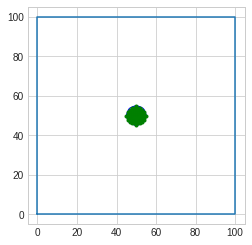

In [25]:
init()
equalize_map()

[[186.54647079 376.74829557 272.11006115 356.10910667]] 

[[0.40507875 0.39212699 0.58971266 1.09634835 0.18476596 0.95029608
  0.54605809 0.31251454]] 

[[2.59078091 2.83984763]] 

[[126.82523276 431.42917299 203.45891123  88.19434424]] 

[[1.40553379 0.91342214 2.17573267 1.10198181 0.88502757 1.26566523
  1.73529859 0.62044398]] 

[[4.34507393 4.66559066]] 

[[306.06552925 257.18947819 119.34434666 412.50998278]] 

[[0.26461834 0.37623662 0.57578833 0.29651035 0.44842369 0.37849742
  0.36520257 0.14651378]] 

[[3.76635281 2.66778656]] 

[[ 20.38976065 150.70930899 277.95421699 243.89068966]] 

[[0.87380377 1.03899704 0.85751778 1.33808135 1.32920249 1.56730494
  1.41063602 1.74592603]] 

[[4.39826686 4.28157344]] 

[[291.39582348 159.67474313 224.99710082 162.87763677]] 

[[0.82312838 1.08099564 1.51247078 1.18962328 0.63021741 1.18334608
  0.50166183 0.44066767]] 

[[3.5017898  2.92998898]] 

[[127.79062513 187.70751071 311.87539118 144.86448547]] 

[[0.51603025 1.64411751 0.688122


[[3.83920311 3.1028921 ]] 

[[118.98146405 178.54573657 280.68856216 142.23487659]] 

[[0.72481556 1.0538924  0.57208307 0.84522754 0.54864054 0.68254261
  0.91037673 0.3838478 ]] 

[[3.24817351 3.40805137]] 

[[ 74.2307733  252.4972174  169.90507999 117.97835611]] 

[[0.70641555 1.47493234 0.85632094 0.97053934 0.77151986 1.28672694
  0.51615314 0.57410333]] 

[[3.38108708 3.45504633]] 

[[318.87075938 146.73005166 269.30566196 161.45100432]] 

[[0.59881816 0.17774256 0.6612146  0.67449174 0.75509453 0.92772854
  0.41020143 0.6258634 ]] 

[[4.17740049 3.40781734]] 

[[189.42834301 387.74982898 281.63372562 367.09722261]] 

[[0.56807191 1.13073856 0.69750954 0.73034138 0.6244345  0.41457284
  1.39203306 0.46284072]] 

[[3.17120031 3.0700616 ]] 

[[ 99.97701865 349.93255021 165.48447618  85.33494392]] 

[[0.70989753 0.66733997 1.29711012 0.67180293 0.29496442 0.698418
  1.24249547 0.2587056 ]] 

[[3.93497108 4.13127792]] 

[[244.33825919 221.4291122  112.90016273 344.94665477]] 

[[0.8

[[277.02362447 125.94197856 235.22327841 136.77286586]] 

[[1.60893001 0.3964372  1.11428769 0.87800158 1.60707966 1.57339646
  0.34556017 1.56478412]] 

[[4.83834253 3.9247286 ]] 

[[185.17349704 380.02502485 275.61825512 360.23521157]] 

[[0.55981796 1.38231878 0.85740863 0.88627489 0.83399778 0.79904226
  1.43909143 0.71313654]] 

[[3.36702413 3.24775884]] 

[[ 89.88288598 303.28921756 147.90460132  79.86155279]] 

[[1.75459316 0.85595059 1.30804644 1.05339219 1.40132703 1.46997198
  1.58975777 0.60201105]] 

[[4.41966854 4.79374688]] 

[[209.76397715 194.32576064 101.34907462 300.98819365]] 

[[1.14454845 0.80571489 1.56616276 1.26688395 1.57747392 0.74336589
  1.3916113  0.54633979]] 

[[5.18680532 3.62679132]] 

[[ 21.91119347 103.27051712 190.54178395 160.3168539 ]] 

[[0.86287391 0.86338811 0.90401344 1.3559699  1.25339575 1.84114908
  1.17465431 1.7505328 ]] 

[[4.33649964 4.21882445]] 

[[336.51992436 156.62834226 218.68849827 166.35365488]] 

[[0.38252011 0.55457749 0.981944

[[ 20.98561435  72.74967622 132.73696373 107.8220963 ]] 

[[0.83699624 0.98771409 1.02750008 1.78013908 1.41225293 1.96976883
  1.57493862 1.73035441]] 

[[4.40704022 4.26367694]] 

[[ 54.20030618 192.90163816 135.82699718  92.29778928]] 

[[0.15353891 0.29784267 0.12673812 0.13604368 0.17775999 0.18652833
  0.16605205 0.22860333]] 

[[2.28126978 2.35465107]] 

[[187.97852126  85.44498341 155.50998998 101.49603369]] 

[[0.91777448 0.91472542 1.20500025 0.81785453 0.70603647 0.60691826
  0.51044444 0.77657885]] 

[[4.51133475 3.76481576]] 

[[170.23946975 351.42151994 254.53103223 332.98145428]] 

[[0.66463722 1.02075153 0.77682522 1.10410436 0.50640086 0.7434731
  1.33778978 0.50645969]] 

[[3.16227872 3.22213118]] 

[[140.05702837 142.59016963  82.02595815 213.20864676]] 

[[1.21996355 0.70499603 1.50921771 1.32912858 1.54700684 0.5587447
  1.45485609 0.53190727]] 

[[5.14598558 3.56487226]] 

[[ 20.78189994  69.87781546 127.30067069 102.98184098]] 

[[1.16944377 1.09648359 1.14080024

[[ 47.2415305  171.02159265 125.9146766   85.79155082]] 

[[0.80886106 1.90583446 0.91266242 1.29679091 1.17198255 1.41338399
  0.8134906  0.84974066]] 

[[3.62856146 3.63262501]] 

[[125.27298566  53.51186614  98.91267241  71.9008814 ]] 

[[0.96189729 0.75759681 1.20361441 0.82165925 0.86006653 0.83724449
  0.51175106 0.82765716]] 

[[4.60541533 3.83037649]] 

[[166.43325601 343.5513912  248.77178656 325.56684146]] 

[[0.36400615 0.35001522 0.2881469  0.53602578 0.0959563  0.22955704
  0.62323555 0.1549673 ]] 

[[2.41167084 2.53400164]] 

[[ 83.98493899 102.277305    66.70405919 145.47327855]] 

[[2.06879202 0.78349221 1.59736078 1.6431251  1.03425854 0.84972534
  2.01533359 0.62268683]] 

[[5.15134311 3.59274291]] 

[[ 45.5444968  165.15945293 122.10360073  83.24176317]] 

[[1.72343103 2.77703471 1.27766116 2.2131023  2.28385126 2.2898523
  1.57757067 1.86369644]] 

[[3.65302499 3.49120545]] 

[[116.98825365  49.20771435  91.51601977  67.79740881]] 

[[0.41936285 0.10224882 0.1984315

[[ 38.2144134  137.79889284 104.58391036  71.88703644]] 

[[0.81885599 1.28540124 0.46011032 1.1709302  1.30008199 0.96316894
  0.88207501 0.99331673]] 

[[3.48830143 3.54567308]] 

[[166.43325817 343.5513927  248.77178982 325.56684386]] 

[[0.36400515 0.3500148  0.28814615 0.53602389 0.09595642 0.22955603
  0.62323431 0.15496701]] 

[[2.41166993 2.53400001]] 

[[ 35.84025781 130.89614107  99.88539385  68.63091921]] 

[[0.39478921 0.32385547 0.23900187 0.24886796 0.27906492 0.43349657
  0.20935698 0.3570093 ]] 

[[2.54309083 2.55780807]] 

[[170.78559354 351.84205088 255.36466833 333.63758065]] 

[[0.71659124 1.39213369 0.85363007 1.01183323 0.74208832 0.70037947
  1.64751455 0.68698136]] 

[[3.3638039  3.29729874]] 

[[ 38.21441406 137.79889345 104.583911    71.88703706]] 

[[0.8188557  1.28540154 0.46011026 1.17093047 1.30008218 0.96316881
  0.8820751  0.99331656]] 

[[3.48830139 3.54567307]] 

[[166.43325817 343.5513927  248.77178982 325.56684386]] 

[[0.36400515 0.3500148  0.288146

[[ 38.21441406 137.79889345 104.58391099  71.88703705]] 

[[0.8188557  1.28540154 0.46011026 1.17093046 1.30008218 0.96316881
  0.8820751  0.99331656]] 

[[3.48830139 3.54567307]] 

[[166.43325817 343.5513927  248.77178982 325.56684386]] 

[[0.36400515 0.3500148  0.28814615 0.53602389 0.09595642 0.22955603
  0.62323431 0.15496701]] 

[[2.41166993 2.53400001]] 

[[ 35.84025783 130.89614108  99.88539386  68.63091922]] 

[[0.39478922 0.32385548 0.23900188 0.24886797 0.27906493 0.43349658
  0.20935699 0.35700931]] 

[[2.54309084 2.55780808]] 

[[170.78559354 351.84205088 255.36466833 333.63758065]] 

[[0.71659124 1.39213369 0.85363007 1.01183323 0.74208832 0.70037947
  1.64751455 0.68698136]] 

[[3.3638039  3.29729874]] 

[[ 38.21441406 137.79889345 104.58391099  71.88703705]] 

[[0.8188557  1.28540154 0.46011026 1.17093046 1.30008218 0.96316881
  0.8820751  0.99331656]] 

[[3.48830139 3.54567307]] 

[[166.43325817 343.5513927  248.77178982 325.56684386]] 

[[0.36400515 0.3500148  0.288146

[[ 35.84025783 130.89614108  99.88539386  68.63091922]] 

[[0.39478922 0.32385548 0.23900188 0.24886797 0.27906493 0.43349658
  0.20935699 0.35700931]] 

[[2.54309084 2.55780808]] 

[[170.78559354 351.84205088 255.36466833 333.63758065]] 

[[0.71659124 1.39213369 0.85363007 1.01183323 0.74208832 0.70037947
  1.64751455 0.68698136]] 

[[3.3638039  3.29729874]] 

[[ 38.21441406 137.79889345 104.58391099  71.88703705]] 

[[0.8188557  1.28540154 0.46011026 1.17093046 1.30008218 0.96316881
  0.8820751  0.99331656]] 

[[3.48830139 3.54567307]] 

[[166.43325817 343.5513927  248.77178982 325.56684386]] 

[[0.36400515 0.3500148  0.28814615 0.53602389 0.09595642 0.22955603
  0.62323431 0.15496701]] 

[[2.41166993 2.53400001]] 

[[ 35.84025783 130.89614108  99.88539386  68.63091922]] 

[[0.39478922 0.32385548 0.23900188 0.24886797 0.27906493 0.43349658
  0.20935699 0.35700931]] 

[[2.54309084 2.55780808]] 

[[170.78559354 351.84205088 255.36466833 333.63758065]] 

[[0.71659124 1.39213369 0.853630

[[170.78559354 351.84205088 255.36466833 333.63758065]] 

[[0.71659124 1.39213369 0.85363007 1.01183323 0.74208832 0.70037947
  1.64751455 0.68698136]] 

[[3.3638039  3.29729874]] 

[[ 38.21441406 137.79889345 104.58391099  71.88703705]] 

[[0.8188557  1.28540154 0.46011026 1.17093046 1.30008218 0.96316881
  0.8820751  0.99331656]] 

[[3.48830139 3.54567307]] 

[[166.43325817 343.5513927  248.77178982 325.56684386]] 

[[0.36400515 0.3500148  0.28814615 0.53602389 0.09595642 0.22955603
  0.62323431 0.15496701]] 

[[2.41166993 2.53400001]] 

[[ 35.84025783 130.89614108  99.88539386  68.63091922]] 

[[0.39478922 0.32385548 0.23900188 0.24886797 0.27906493 0.43349658
  0.20935699 0.35700931]] 

[[2.54309084 2.55780808]] 

[[170.78559354 351.84205088 255.36466833 333.63758065]] 

[[0.71659124 1.39213369 0.85363007 1.01183323 0.74208832 0.70037947
  1.64751455 0.68698136]] 

[[3.3638039  3.29729874]] 

[[ 38.21441406 137.79889345 104.58391099  71.88703705]] 

[[0.8188557  1.28540154 0.460110

[[166.43325817 343.5513927  248.77178982 325.56684386]] 

[[0.36400515 0.3500148  0.28814615 0.53602389 0.09595642 0.22955603
  0.62323431 0.15496701]] 

[[2.41166993 2.53400001]] 

[[ 35.84025783 130.89614108  99.88539386  68.63091922]] 

[[0.39478922 0.32385548 0.23900188 0.24886797 0.27906493 0.43349658
  0.20935699 0.35700931]] 

[[2.54309084 2.55780808]] 

[[170.78559354 351.84205088 255.36466833 333.63758065]] 

[[0.71659124 1.39213369 0.85363007 1.01183323 0.74208832 0.70037947
  1.64751455 0.68698136]] 

[[3.3638039  3.29729874]] 

[[ 38.21441406 137.79889345 104.58391099  71.88703705]] 

[[0.8188557  1.28540154 0.46011026 1.17093046 1.30008218 0.96316881
  0.8820751  0.99331656]] 

[[3.48830139 3.54567307]] 

[[166.43325817 343.5513927  248.77178982 325.56684386]] 

[[0.36400515 0.3500148  0.28814615 0.53602389 0.09595642 0.22955603
  0.62323431 0.15496701]] 

[[2.41166993 2.53400001]] 

[[ 35.84025783 130.89614108  99.88539386  68.63091922]] 

[[0.39478922 0.32385548 0.239001

[[ 38.21441406 137.79889345 104.58391099  71.88703705]] 

[[0.8188557  1.28540154 0.46011026 1.17093046 1.30008218 0.96316881
  0.8820751  0.99331656]] 

[[3.48830139 3.54567307]] 

[[166.43325817 343.5513927  248.77178982 325.56684386]] 

[[0.36400515 0.3500148  0.28814615 0.53602389 0.09595642 0.22955603
  0.62323431 0.15496701]] 

[[2.41166993 2.53400001]] 

[[ 35.84025783 130.89614108  99.88539386  68.63091922]] 

[[0.39478922 0.32385548 0.23900188 0.24886797 0.27906493 0.43349658
  0.20935699 0.35700931]] 

[[2.54309084 2.55780808]] 

[[170.78559354 351.84205088 255.36466833 333.63758065]] 

[[0.71659124 1.39213369 0.85363007 1.01183323 0.74208832 0.70037947
  1.64751455 0.68698136]] 

[[3.3638039  3.29729874]] 

[[ 38.21441406 137.79889345 104.58391099  71.88703705]] 

[[0.8188557  1.28540154 0.46011026 1.17093046 1.30008218 0.96316881
  0.8820751  0.99331656]] 

[[3.48830139 3.54567307]] 

[[166.43325817 343.5513927  248.77178982 325.56684386]] 

[[0.36400515 0.3500148  0.288146

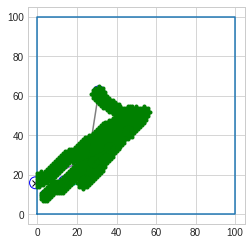

In [26]:
smart_scatter()
equalize_map()